### Siamese Neural Network 

This model is trained on http://www.cs.cmu.edu/~keystroke/ dataset by creating a huge sample of 24000 data that is balanced in having equal number of genuine and imposter pairs. 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.layers import Dense, Activation, Input, Lambda, BatchNormalization, Activation
from tensorflow.keras import backend as K
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import confusion_matrix
import random

%matplotlib inline

In [2]:
data = pd.read_csv('DSL-StrongPasswordData.csv')

In [3]:
data.head()

,subject,sessionIndex,rep,H.period,DD.period.t,UD.period.t,H.t,DD.t.i,UD.t.i,H.i,...,H.a,DD.a.n,UD.a.n,H.n,DD.n.l,UD.n.l,H.l,DD.l.Return,UD.l.Return,H.Return
0,s002,1,1,0.1491,0.3979,0.2488,0.1069,0.1674,0.0605,0.1169,...,0.1349,0.1484,0.0135,0.0932,0.3515,0.2583,0.1338,0.3509,0.2171,0.0742
1,s002,1,2,0.1111,0.3451,0.2340,0.0694,0.1283,0.0589,0.0908,...,0.1412,0.2558,0.1146,0.1146,0.2642,0.1496,0.0839,0.2756,0.1917,0.0747
2,s002,1,3,0.1328,0.2072,0.0744,0.0731,0.1291,0.0560,0.0821,...,0.1621,0.2332,0.0711,0.1172,0.2705,0.1533,0.1085,0.2847,0.1762,0.0945
3,s002,1,4,0.1291,0.2515,0.1224,0.1059,0.2495,0.1436,0.1040,...,0.1457,0.1629,0.0172,0.0866,0.2341,0.1475,0.0845,0.3232,0.2387,0.0813
4,s002,1,5,0.1249,0.2317,0.1068,0.0895,0.1676,0.0781,0.0903,...,0.1312,0.1582,0.0270,0.0884,0.2517,0.1633,0.0903,0.2517,0.1614,0.0818


In [4]:
subjects = data["subject"].unique()
subjects

array(['s002', 's003', 's004', 's005', 's007', 's008', 's010', 's011',
       's012', 's013', 's015', 's016', 's017', 's018', 's019', 's020',
       's021', 's022', 's024', 's025', 's026', 's027', 's028', 's029',
       's030', 's031', 's032', 's033', 's034', 's035', 's036', 's037',
       's038', 's039', 's040', 's041', 's042', 's043', 's044', 's046',
       's047', 's048', 's049', 's050', 's051', 's052', 's053', 's054',
       's055', 's056', 's057'], dtype=object)

In [5]:
#this piece of code creates paired data to be fed as input to the model. 
random.seed(42)
subject_count = 50
data_count = 400
count = 0
genuine_data = np.zeros([12000,2,31])
y_genuine = []
for i in range(subject_count):
    for j in range(int(12000/subject_count)):
        ind1 = 0
        ind2 = 0
        while ind1 == ind2:
            ind1 = np.random.randint(data_count)
            ind2 = np.random.randint(data_count)
        x1 = data.loc[data.subject == subjects[i], 'H.period':'H.Return'][ind1:ind1+1]
        x2 = data.loc[data.subject == subjects[i], 'H.period':'H.Return'][ind2:ind2+1]
        genuine_data[count,0,:] = x1
        genuine_data[count,1,:] = x2
        y_genuine.append(1)
        count += 1
imposter_data = np.zeros([12000,2,31])
y_imposter = []
count = 0
for i in range(int(12000/data_count)):
    for j in range(data_count):
        while True:
            ind1 = np.random.randint(subject_count)
            ind2 = np.random.randint(subject_count)
            if ind1 != ind2:
                break
        x1 = data.loc[data.subject == subjects[ind1], 'H.period':'H.Return'][j:j+1]
        x2 = data.loc[data.subject == subjects[ind2], 'H.period':'H.Return'][j:j+1]
        imposter_data[count,0,:] = x1
        imposter_data[count,1,:] = x2
        y_imposter.append(0) 
        count += 1
X = np.concatenate([genuine_data, imposter_data], axis=0)
Y = pd.DataFrame(y_genuine + y_imposter)       

In [6]:
X.shape

(24000, 2, 31)

In [7]:
Y.shape

(24000, 1)

In [8]:
random.seed(42)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.2, stratify=Y)

In [9]:
print('x_train shape',x_train.shape)
print('y_train shape', y_train.shape)
print('x_test shape',x_test.shape)
print('y_test shape', y_test.shape)

x_train shape (19200, 2, 31)
y_train shape (19200, 1)
x_test shape (4800, 2, 31)
y_test shape (4800, 1)


In [10]:
def build_base_network():
    network = Sequential()
    network.add(Dense(100,input_dim=31,activation='relu'))
    network.add(Dense(50))
    network.add(BatchNormalization())
    network.add(Activation('relu'))
    network.add(Dense(25))
    network.add(BatchNormalization())
    network.add(Activation('relu'))
    return network

In [11]:
input_dim = x_train.shape[2:]
stroke_a = Input(shape=input_dim)
stroke_b = Input(shape=input_dim)
print('input_dim',input_dim)

input_dim (31,)


In [12]:
base_network = build_base_network()
feat_vecs_a = base_network(stroke_a)
feat_vecs_b = base_network(stroke_b)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [13]:
# 3 different distance function that can be tried for the Lambda layer

def cosine_distance(vests):
    x, y = vests
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    return -K.mean(x * y, axis=-1, keepdims=True)

def abs_diff(x): return K.abs(x[0] - x[1])

def euclidean_distance(x):
    return K.sqrt(K.sum(K.square(x[0] - x[1]), axis=1, keepdims=True))

In [14]:
diff = Lambda(function=euclidean_distance,output_shape=lambda x: x[0])([feat_vecs_a, feat_vecs_b])

In [15]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [16]:
pred1 = Dense(25, activation = 'relu')(diff)
pred2 = Dense(10)(diff)
norm = BatchNormalization()(pred2)
act = Activation('relu')(norm)
prediction = Dense(1, activation='sigmoid')(act)

In [17]:
model = Model([stroke_a, stroke_b], prediction)

In [18]:
model.compile(loss='binary_crossentropy',optimizer='adam', metrics = ['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 31)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 31)]         0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 25)           9825        input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           sequential[1][0]             

In [20]:
stroke_1 = np.array(x_train[:, 0])
stroke_2 = np.array(x_train[:, 1])
stroke_1.shape

(19200, 31)

In [21]:
history = model.fit([stroke_1, stroke_2],np.array(y_train),epochs=50,batch_size=100, validation_split=0.2)

Train on 15360 samples, validate on 3840 samples
Epoch 1/50
15360/15360 [==============================] - 4s 290us/sample - loss: 0.5669 - acc: 0.7085 - val_loss: 0.5930 - val_acc: 0.6419
Epoch 2/50
15360/15360 [==============================] - 2s 134us/sample - loss: 0.4150 - acc: 0.8130 - val_loss: 0.4086 - val_acc: 0.8177
Epoch 3/50
15360/15360 [==============================] - 2s 154us/sample - loss: 0.3625 - acc: 0.8398 - val_loss: 0.3658 - val_acc: 0.8398
Epoch 4/50
15360/15360 [==============================] - 2s 127us/sample - loss: 0.3287 - acc: 0.8559 - val_loss: 0.3552 - val_acc: 0.8456
Epoch 5/50
15360/15360 [==============================] - 2s 118us/sample - loss: 0.3052 - acc: 0.8691 - val_loss: 0.3379 - val_acc: 0.8557
Epoch 6/50
15360/15360 [==============================] - 2s 115us/sample - loss: 0.2857 - acc: 0.8802 - val_loss: 0.3247 - val_acc: 0.8570
Epoch 7/50
15360/15360 [==============================] - 2s 122us/sample - loss: 0.2710 - acc: 0.8884 - val_lo

In [22]:
pred = np.rint(model.predict([x_test[:, 0], x_test[:, 1]]))
pred

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [0.],
       [0.]], dtype=float32)

In [23]:
y_test

,0
6151,1
20036,0
7301,1
16931,0
8055,1
...,...
1089,1
11165,1
9856,1
19424,0


In [24]:
test_scores = model.evaluate([x_test[:, 0], x_test[:, 1]], y_test, verbose = 0)
print('Test accuracy:', test_scores[1])

Test accuracy: 0.91083336


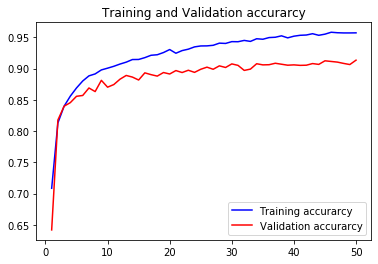

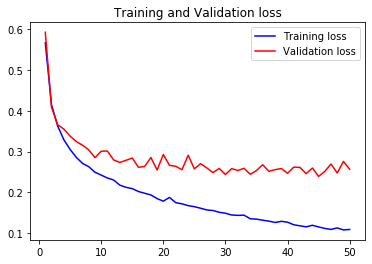

In [25]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [26]:
confusion_matrix(pred,y_test)

array([[2136,  164],
       [ 264, 2236]], dtype=int64)

In [27]:
# Save Weights + Architecture
model.save_weights('model_weights.h5')
with open('model_architecture.json', 'w') as f:
    f.write(model.to_json())
print('saved')

saved


In [28]:
#load the model

json_file = open('model_architecture.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_weights.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate([x_test[:, 0], x_test[:, 1]], y_test, verbose = 0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Loaded model from disk
acc: 91.08%


In [29]:
# through EDA observation from t-SNE plot we find s002 and s003 subjects forming clusters 
# nearby and quite overlapping, telling us their patterns being quite similar, and this model 
# finds it actually difficult to differentiate both giving us prediction of 1 that is both same 

x1 = np.array(data.loc[data.subject == 's003', 'H.period':'H.Return'][1:2])
x2 = np.array(data.loc[data.subject == 's002', 'H.period':'H.Return'][1:2])
pred = loaded_model.predict([x1,x2])
np.rint(pred)

array([[1.]], dtype=float32)

In [33]:
# another case as seen from t-SNE plot done in EDA shows s054 subject has 2 very different styles of typing 
# hence x1 and x2 give 0 that is diffrent while x1 and x3 give same that is 1 

x1 = np.array(data.loc[data.subject == 's054', 'H.period':'H.Return'][1:2])
x2 = np.array(data.loc[data.subject == 's054', 'H.period':'H.Return'][25:26])
x3 = np.array(data.loc[data.subject == 's054', 'H.period':'H.Return'][250:251])
pred = loaded_model.predict([x1,x2])
print('x1 and x2: ', np.rint(pred))
pred = loaded_model.predict([x1,x3])
print('x1 and x3: ', np.rint(pred))

x1 and x2:  [[0.]]
x1 and x3:  [[1.]]
